In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn
print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix
import itertools


from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/3188123076.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


imblearn version:  0.12.0


# Plotting Functions

In [2]:
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [201]:
def plot_heatmap(dist, observed_pred, probabilities, title): 
    pred_samples = dist.sample(torch.Size((100,))).exp()
    title = str(title)
    # probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
    probabilities_np = probabilities.numpy()
    class0_prob = probabilities_np[0, :]
    class1_prob = probabilities_np[1, :]
    
    num_samples = class0_prob.shape[0]
    side_length = int(np.ceil(np.sqrt(num_samples)))
    grid_data_class0 = np.full((side_length, side_length), np.nan)
    grid_data_class0.flat[:num_samples] = class0_prob
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[0].set_title('Probability of Class 0 - '+title)
    ax[0].axis('off');
    fig.colorbar(ax[0].imshow(grid_data_class0, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[0], label='Class 0')
    
    # Class 1
    grid_data_class1 = np.full((side_length, side_length), np.nan)
    grid_data_class1.flat[:num_samples] = class1_prob
    ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal')
    ax[1].set_title('Probability of Class 1 - '+title)
    ax[1].axis('off')
    fig.colorbar(ax[1].imshow(grid_data_class1, cmap='RdYlGn', origin='lower', aspect='equal'), ax=ax[1], label='Class 1')
    fig.suptitle('nek2 generated probabilities from posterior distribution- '+title)
    plt.savefig('nek2_probabilities_'+title+'.png')
    plt.show();

In [4]:
def plot_tsne(input, y_true, n_components): 
    tsne = TSNE(n_components=n_components, random_state=42)
    embedded_data = tsne.fit_transform(input)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=y_true, cmap='viridis')
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Labels')
    plt.show();

In [32]:
def plot_hist(observed_pred, title): 
    var = observed_pred.variance.numpy().tolist()
    # plot class 0 and class 1 sep
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    class0_var = observed_pred.variance[0].numpy()
    class1_var = observed_pred.variance[1].numpy()
    # class 0 
    
    sns.histplot(class0_var, bins=20, kde =True,color ='blue', ax=ax[0])
    # sns.kdeplot(class0_var, color='red', ax=ax[0])
    ax[0].set_title(f'Class 0 Variance Distribution')
    ax[0].set_xlabel('Variance')
    ax[0].set_ylabel('Density')
    ax[0].grid(True)


    # class 1
    sns.histplot(class1_var, bins=20, kde =True, color='green',ax=ax[1])
    # sns.kdeplot(class1_var, color='orange', ax=ax[1])
    ax[1].set_title(f'Class 1 Variance Distribution')
    ax[1].set_xlabel('Variance')
    ax[1].set_ylabel('Density')
    ax[1].grid(True)


    plt.suptitle('Distribution of Variances for Each Class -' + title)
    plt.legend()
    plt.grid(True) 
    plt.tight_layout()  
    plt.savefig(f'nek2_variance_dist_{title}.png')
    plt.show();

In [215]:
def plot_variance_cm(observed_pred, true_labels, predictions, title):
    class0_var = observed_pred.variance[0].numpy()
    class1_var = observed_pred.variance[1].numpy()
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, true_pos].numpy()
    var_fn = observed_pred.variance[0, true_neg].numpy()
    
    tp_var0 = class0_var[true_pos]
    tp_var1 = class1_var[true_pos]
    tn_var0 = class0_var[true_neg]
    tn_var1 = class1_var[true_neg]
    fp_var0 = class0_var[false_pos]
    fp_var1 = class1_var[false_pos]
    fn_var0 = class0_var[false_neg]
    fn_var1 = class1_var[false_neg]

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    sns.heatmap([tp_var0, tp_var1], cmap='RdYlBu_r', ax=ax[0, 0])
    ax[0, 0].set_title('True Positives')

    sns.heatmap([tn_var0, tn_var1], cmap='RdYlBu_r', ax=ax[0, 1])
    ax[1, 1].set_title('True Negatives')

    sns.heatmap([fp_var0, fp_var1], cmap='RdYlBu_r', ax=ax[1, 0])
    ax[0, 1].set_title('False Positives')

    sns.heatmap([fn_var0, fn_var1], cmap='RdYlBu_r', ax=ax[1, 1])
    ax[1, 0].set_title('False Negatives')

    plt.suptitle('NEK2 Binding Predictions: Sample Variance - ' + title)
    plt.tight_layout()
    plt.savefig(f'NEK2_bind_heatmap_cm_{title}.png')
    plt.show();

In [77]:
def plot_hist_tp_tn(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, true_pos].numpy()

    plt.figure(figsize=(10,6))
    plt.hist(var_tp, bins=10, alpha=0.5, density=True, label = 'True Positive')
    plt.hist(var_tn, bins=10, alpha=0.5, density=True, label = 'True negative')
    # print(f'tp var: {var_tp}')
    # print(f'tn var: {var_tn}')
    plt.xlabel('Variance')
    plt.legend()
    plt.ylabel('Density')
    plt.title(f'Variance Distribution for TP and TN - {title}')
    plt.grid(True)
    plt.savefig(f'nek2_variance_dist_tp_tn_{title}.png')
    plt.show();

In [191]:
def plot_cm_dist(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    plt.hist(var_tp, color='green', alpha=0.7)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    

    plt.subplot(2, 2, 2)
    plt.hist(var_fp, color='red', alpha=0.7)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    plt.hist(var_fn, color='orange', alpha=0.7)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    plt.hist(var_tn, color='blue', alpha=0.7)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'Variance Distribution of Predictions {title}', fontsize=14, y=1.05)

    plt.savefig(f'nek2_var_dist_tptnfpfn_{title}.png')

    plt.show();

In [197]:
def plot_cm_dist_kde(observed_pred, predictions, true_labels, title): 
    # predictions = predictions.numpy() 
    true_labels = true_labels.numpy()
    print(f'predictions shape: {predictions.shape}')
    print(f'true labels shape: {true_labels.shape}')
    
    true_pos = np.where((predictions == 1) & (true_labels == 1))[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0))[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0))[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1))[0] 

    var_tp = observed_pred.variance[1, true_pos].numpy()
    var_tn = observed_pred.variance[0, true_neg].numpy()
    var_fp = observed_pred.variance[1, false_pos].numpy()
    var_fn = observed_pred.variance[0, false_neg].numpy()

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 4)
    sns.histplot(var_tp, kde=True,color='green', bins=10)
    plt.title('True Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 1)
    sns.histplot(var_tn, kde=True,color='blue', bins=10)
    plt.title('True Negatives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 2)
    sns.histplot(var_fp, kde=True,color='red', bins=10)
    plt.title('False Positives',fontsize=12)
    plt.xlabel('Variance')

    plt.subplot(2, 2, 3)
    sns.histplot(var_fn, kde=True, color='orange', bins=10)
    plt.title('False Negative', fontsize=12)
    plt.xlabel('Variance')
    
    plt.tight_layout()
    plt.suptitle(f'Variance Distribution of Predictions {title}', fontsize=14, y=1.05)

    plt.savefig(f'nek2_var_dist_tptnfpfn_kde{title}.png')

    plt.show();

In [54]:
def plot_violin(observed_pred, title, class_labels = ['0', '1'],y_max = 10): 
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))


    class0_var = observed_pred.variance[0].numpy() 
    # plt.hist(class0_var, bins=20, alpha=0.5, label=f'Class 0')

    class1_var = observed_pred.variance[1].numpy() 
    # plt.hist(class1_var, bins=20, alpha=0.5, label=f'Class 1')
    sns.violinplot(data=var, inner="quartile")
    # sns.violinplot(data=var, inner="quartile", hue=class_labels)
    sns.violinplot(x='Class', y='Variance', data=df)
  
    plt.set_xlabel('Class')

    plt.grid(True)

    
    # sns.violinplot(data=class1_var.tolist(), inner="quartile")
    # plt.xlabel('Class')

    plt.ylabel('Variance')
    # plt.ylim(0,y_max)
    plt.legend()
    plt.title(f'Variance Distribution - {title}')
    plt.grid(True)
    plt.savefig(f'nek2_violin_{title}.png')
    plt.show();

In [107]:
from sklearn.metrics import roc_curve, auc
def plot_roc(y_true, y_prob):
    y_prob0 = y_prob[0,:]
    y_prob1 = y_prob[1,:]
    fpr0, tpr0, thresholds0 = roc_curve(y_true, y_prob0)
    fpr1, tpr1, thresholds1 = roc_curve(y_true, y_prob1)
    roc_auc0 = auc(fpr0, tpr0)
    roc_auc1 = auc(fpr1, tpr1)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='orange', lw=2, label='class 1 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot(fpr0, tpr0, color='blue', lw=2, label='class 0 ROC curve (area = %0.2f)' % roc_auc0)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('NEK2 ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'NEK2_roc_test.png')
    plt.show(); 


In [108]:
def plot_kde(observed_pred, title): 
    plt.figure(figsize=(8, 6))
    var = observed_pred.variance.numpy().tolist()
    class0_var = observed_pred.variance[0].numpy() 
    class1_var = observed_pred.variance[1].numpy() 
    
    sns.kdeplot(class0_var, label=f'Class 0')
    sns.kdeplot(class1_var, label=f'Class 1')
    plt.xlabel('Variance')
    plt.ylabel('Density')
    plt.title(f'KDE Variances for Each Class - {title}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'nek2_kde_plot_{title}.png')
    plt.show();

In [146]:
def plot_prec_recall(y_true, y_pred, title): 
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.savefig(f'nek2_precision_recall_{title}.png')
    plt.show()

In [8]:
def look_at_data(filepath):
    """5-fold on majority and minority separately, then concat into one df""" 
    df = pd.read_csv(filepath)

    print("Dataset shape:",df.shape)
    print(df.active.value_counts())
    print(df['fold'].unique())
    num_gap = (df.loc[df['active']==0].shape[0]) - (df.loc[df['active']==1].shape[0])
    print("\nDifference in class sample sizes: ",num_gap)

    num_minority = df.loc[df['active']==1].shape[0]
    print("Number of minority samples: ",num_minority)
    # print(df.describe())
    print(f"active/inactive: {df['active'].value_counts()}")
    print(f"active/inactive: {df['active'].value_counts()}")
    counts_per_fold = df.groupby('fold')['active'].value_counts()
    print(counts_per_fold)
    return df

In [9]:
split_path = '../../../data/NEK_data_4Berkeley/NEK2/'
file = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
all_fold_df = look_at_data(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

Dataset shape: (1408, 310)
active
0    1351
1      57
Name: count, dtype: int64
['fold4' 'fold1' 'fold2' 'fold3' 'fold5']

Difference in class sample sizes:  1294
Number of minority samples:  57
active/inactive: active
0    1351
1      57
Name: count, dtype: int64
active/inactive: active
0    1351
1      57
Name: count, dtype: int64
fold   active
fold1  0         271
       1          12
fold2  0         270
       1          12
fold3  0         270
       1          11
fold4  0         270
       1          11
fold5  0         270
       1          11
Name: count, dtype: int64


In [10]:
# train fold 1
split_path = "../../../data/datasets/NEK_data_4Berkeley/NEK2"
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv

train_x_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df_temp = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")

In [11]:
# SMOTE: Adjust imbalanced training data

# transform the dataset
oversample = SMOTE()
new_train_x_df, new_train_y_df = oversample.fit_resample(train_x_df_temp, train_y_df_temp)

# display(new_train_x_df.head)

# display("original training size: ",train_x_df_temp.shape)
# display(train_y_df_temp.value_counts())
# display("SMOTE train set size:",new_train_x_df.shape)
# display(new_train_y_df.value_counts())



# SMOTE 




In [12]:
# save to files 

train_x_df = new_train_x_df
train_y_df = new_train_y_df

train_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainX.csv", index=False)
train_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_trainY.csv", index=False)
test_x_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testX.csv", index=False)
test_y_df.to_csv(split_path+"/NEK2_1_uM_min_50_pct_binding_random_smote_fold1_testY.csv", index=False)




In [13]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_scaled_data = scaling.transform(train_x_df)
test_scaled_data = scaling.transform(test_x_df) 


train_x_temp = train_scaled_data.astype("long")
test_x_temp = test_scaled_data.astype("long")

train_y_temp = train_y_df.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")


train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 

torch.Size([2160, 306])
torch.Size([2160])


In [14]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




In [15]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 

            

    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # get predicted distributions 
            pred_means = dist.loc          # extract means for predicted dist
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions 
            class_pred = self.model(input).loc.max(0)[1].numpy() 
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true, class_names, plot_name): 
        
        y_pred = self.model(x_input).loc.max(0)[1].numpy() 

        cm = confusion_matrix(y_true, y_pred)
        plt.rcParams.update({"font.size": 20})
        label_font = {'size':'18'} 
        ax = plt.figure(figsize=(5,5))
        plt.title(plot_name,fontsize=20)
        plot_confusion_matrix(cm, classes=class_names, normalize=False)
        plt.xlabel("Predicted",fontdict=label_font);
        plt.ylabel("Actual",fontdict=label_font);
        return y_pred
    
    
    def get_metrics(self, x, y_true, y_pred): 
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist 
        # pred_probs = self.likelihood(dist).probs #predicted probabilities 
        # f_mean = dist.mean
        # f_var = dist.variance
        # f_covar = dist.covariance_matrix
        # f_samples = dist.sample(sample_shape=torch.Size(1000))    
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        
        # # roc_auc = roc_auc_score(y_true, y_pred_proba) 
        # # fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
        # # roc_auc_curve = auc(fpr, tpr)
        # # precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_proba)
        # # pr_auc_curve = auc(recall, precision)
        
        
        return accuracy, precision, f1, recall 
            

In [16]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.035   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.748   lengthscale: 1.321   noise: 1.287
Iter 21/300 - Loss: 5.028   lengthscale: 2.202   noise: 1.823
Iter 31/300 - Loss: 4.603   lengthscale: 3.270   noise: 1.894
Iter 41/300 - Loss: 4.276   lengthscale: 4.330   noise: 1.489
Iter 51/300 - Loss: 3.976   lengthscale: 5.286   noise: 0.877
Iter 61/300 - Loss: 3.764   lengthscale: 6.051   noise: 0.397
Iter 71/300 - Loss: 3.642   lengthscale: 6.604   noise: 0.170
Iter 81/300 - Loss: 3.579   lengthscale: 6.984   noise: 0.088
Iter 91/300 - Loss: 3.546   lengthscale: 7.233   noise: 0.056
Iter 101/300 - Loss: 3.535   lengthscale: 7.389   noise: 0.041
Iter 111/300 - Loss: 3.528   lengthscale: 7.486   noise: 0.032
Iter 121/300 - Loss: 3.518   lengthscale: 7.546   noise: 0.027
Iter 131/300 - Loss: 3.521   lengthscale: 7.588   noise: 0.023
Iter 141/300 - Loss: 3.519   lengthscale: 7.619   noise: 0.020
Iter 151/300 - Loss: 3.513   lengthscale: 7.640   noise: 0.018
Ite

In [17]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
# print(f'pred means shape: {train_pred_means.numpy().shape}')
print(f'train predictions: {train_pred}')
print(f'train prediction means: {train_pred_means}')

print(train_pred_means.shape)
train_accuracy, train_precision, train_f1, train_recall = trainer1.get_metrics(train_x, train_y, train_pred)
print(f'accuracy: {train_accuracy}, precision: {train_precision}, f1: {train_f1}, recall: {train_recall}')
# plot_tsne(train_x, train_y, 3)

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


train predictions: [0 0 0 ... 1 1 1]
train prediction means: tensor([[-0.2515, -0.5559, -0.2787,  ..., -7.0320, -6.1377, -6.2422],
        [-6.9036, -5.2924, -6.9631,  ..., -0.2150, -0.4902, -0.3055]])
torch.Size([2, 2160])


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


accuracy: 0.999537037037037, precision: 0.9990749306197965, f1: 0.999537251272559, recall: 1.0


Confusion matrix, without normalization
[[1079    1]
 [   0 1080]]


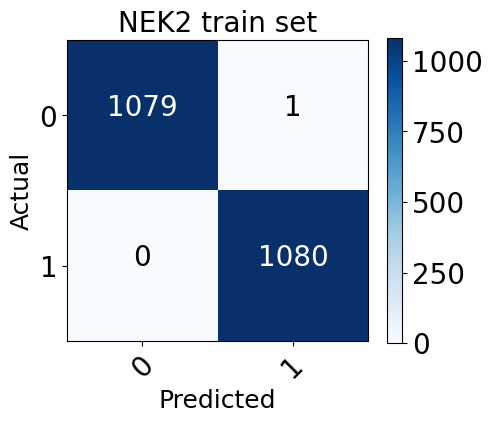

In [185]:
train_cm = confusion_matrix(train_y, train_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

plt.savefig('nek2_bind_cm_train.png')

Confusion matrix, without normalization
[[269   2]
 [  9   3]]


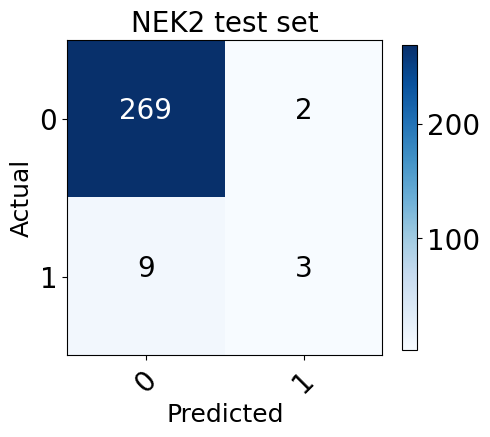

In [187]:
test_cm = confusion_matrix(test_y, test_pred)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  
ax = plt.figure(figsize=(5,5))
plt.title("NEK2 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);
plt.savefig('nek2_bind_cm_test.png')

In [203]:
# Make predictions on test set  
test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)

# print(f'test predictions: {test_pred}')
# print(f'test prediction means: {test_pred_means}')
# print(test_pred_means.shape)
test_accuracy, test_precision, test_f1, test_recall = trainer1.get_metrics(test_x, test_y, test_pred)
print(f'accuracy: {test_accuracy}, precision: {test_precision}, f1: {test_f1}, recall: {test_recall}')


accuracy: 0.9611307420494699, precision: 0.6, f1: 0.35294117647058826, recall: 0.25


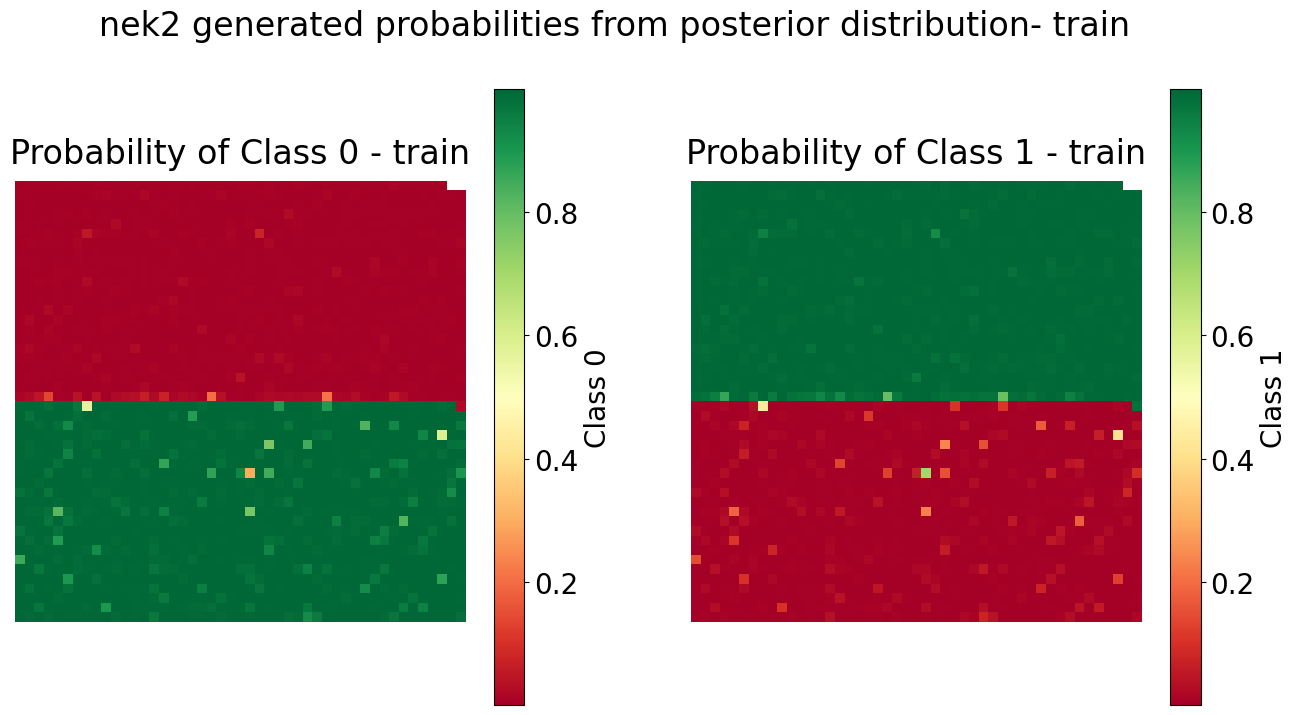

In [202]:
# get train samples 
train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
# TRAIN
plot_heatmap(train_dist, train_observed_pred, train_probabilities, 'train')

In [90]:
train_probabilities

tensor([[0.9984, 0.9884, 0.9985,  ..., 0.0012, 0.0043, 0.0029],
        [0.0016, 0.0116, 0.0015,  ..., 0.9988, 0.9957, 0.9971]])

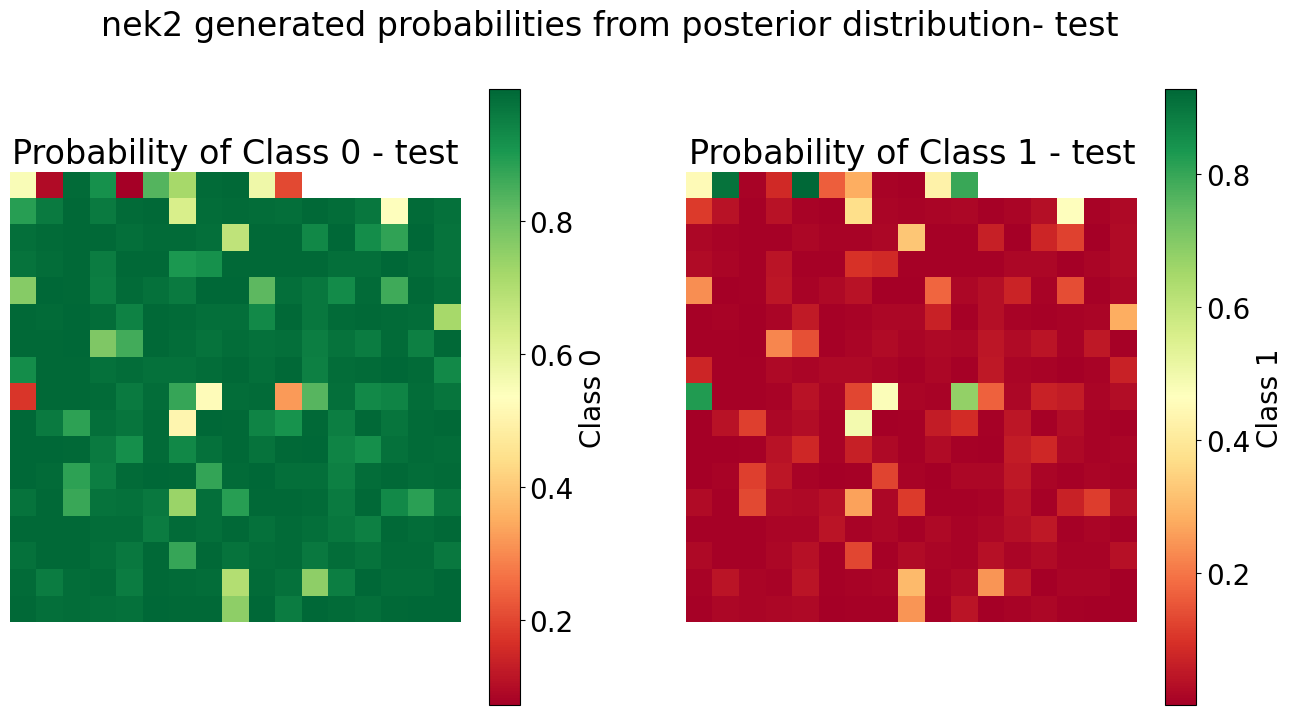

In [204]:
# TEST SET
# # Get confidence regions 
# confidence 
lower, upper = test_observed_pred.confidence_region()

# # Generate samples to get probabilities
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
plot_heatmap(test_dist, test_observed_pred, probabilities, 'test')

In [99]:
probabilities.shape

torch.Size([2, 283])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


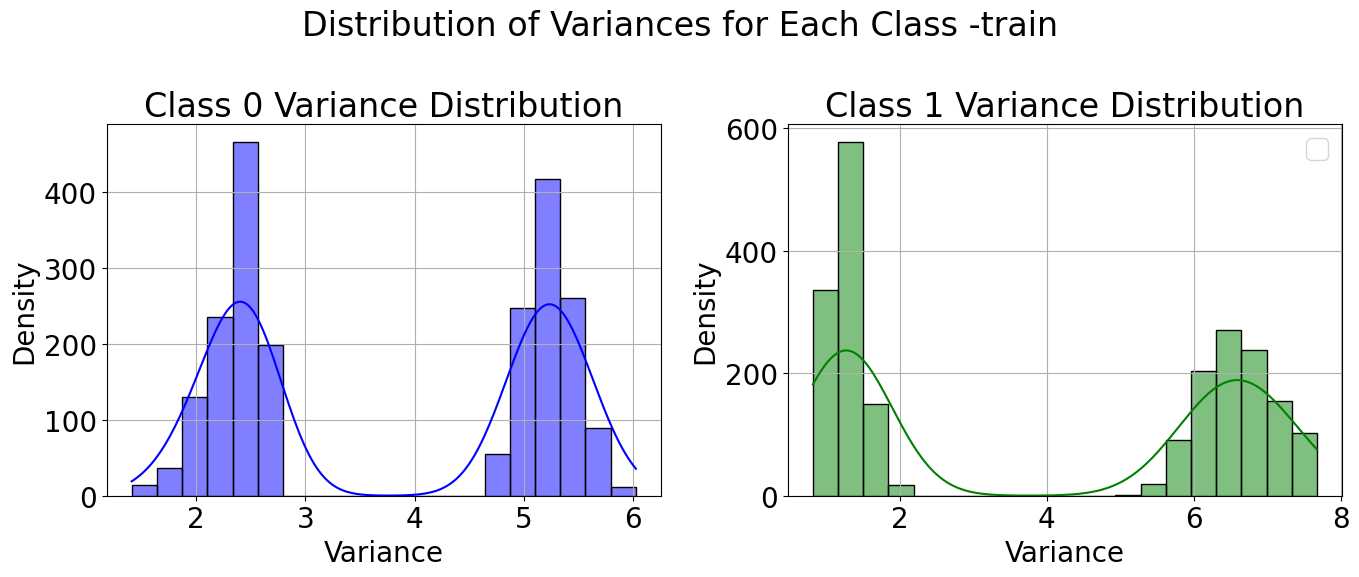

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


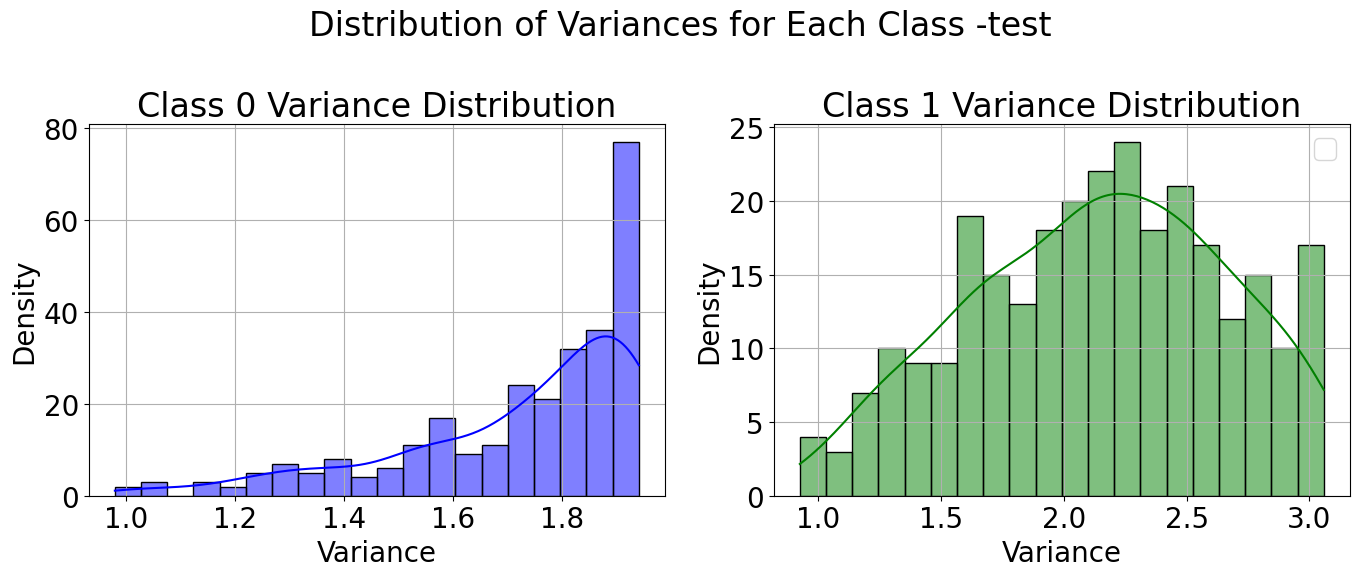

In [198]:
plot_hist(train_observed_pred, 'train')
plot_hist(test_observed_pred, 'test')

In [194]:
train_observed_pred.variance.max()

tensor(7.6732)

predictions shape: (2160,)
true labels shape: (2160,)


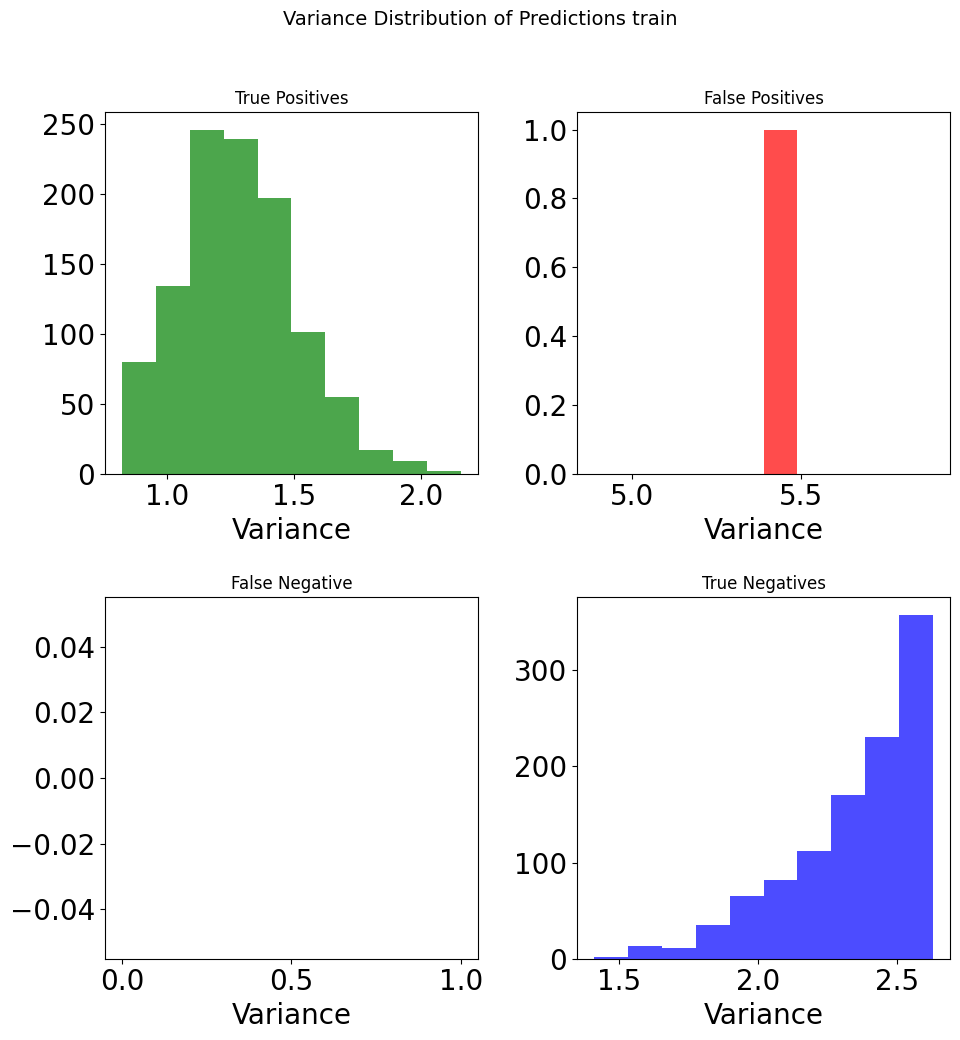

predictions shape: (283,)
true labels shape: (283,)


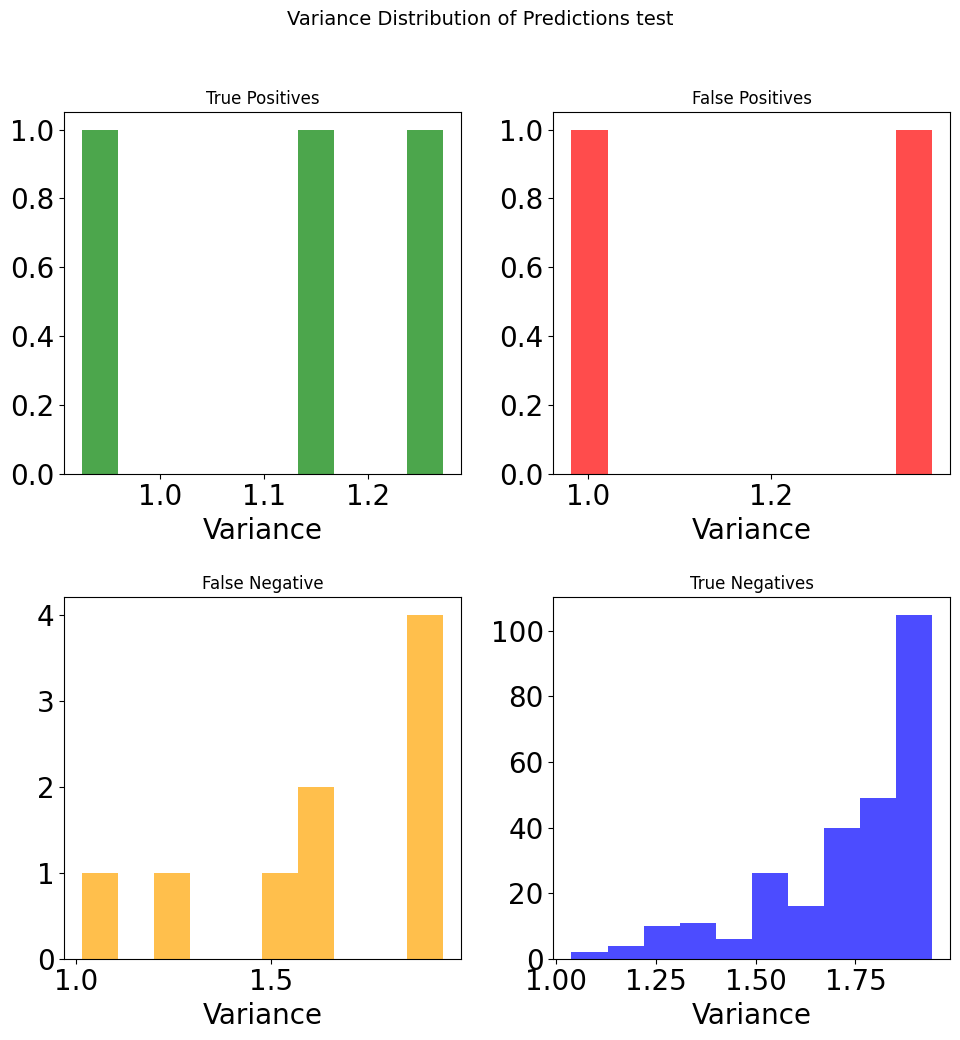

In [199]:
plot_cm_dist(train_observed_pred, train_pred, train_y, 'train')
plot_cm_dist(test_observed_pred, test_pred, test_y, 'test')


predictions shape: (2160,)
true labels shape: (2160,)


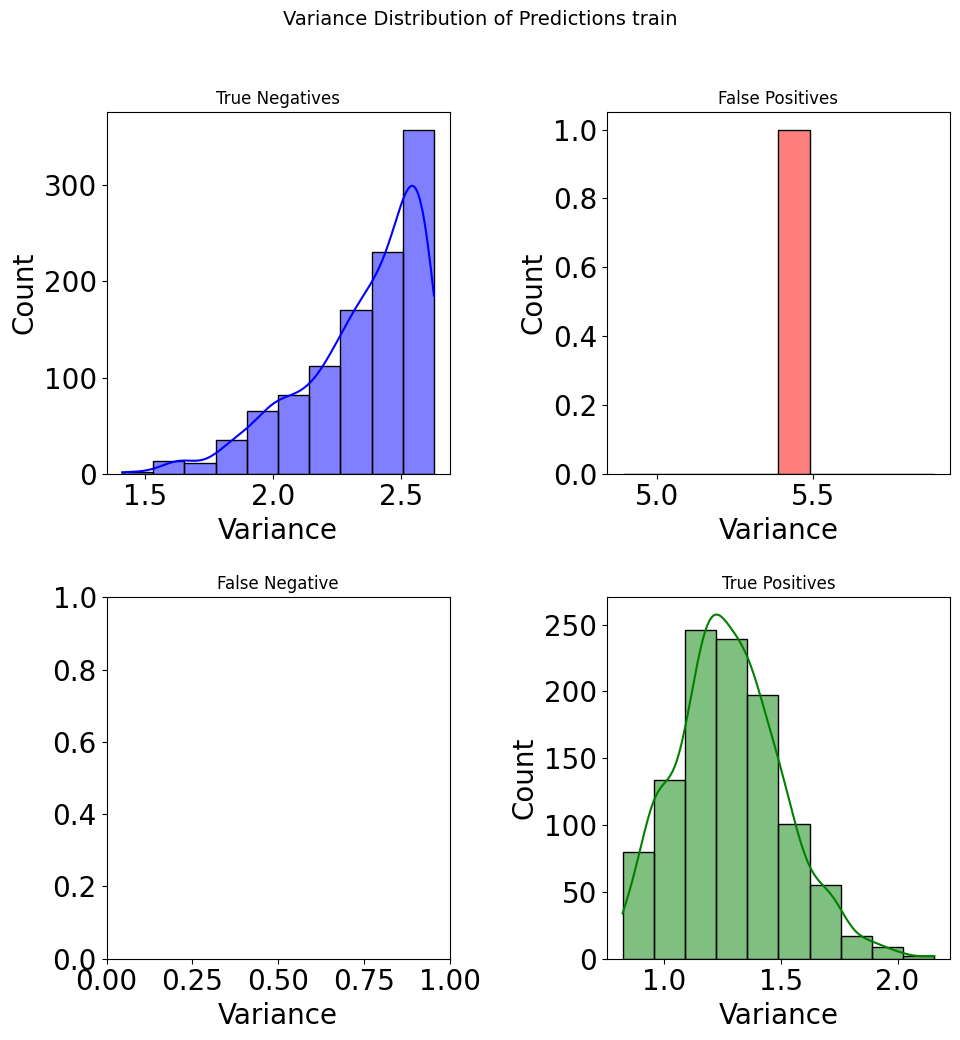

predictions shape: (283,)
true labels shape: (283,)


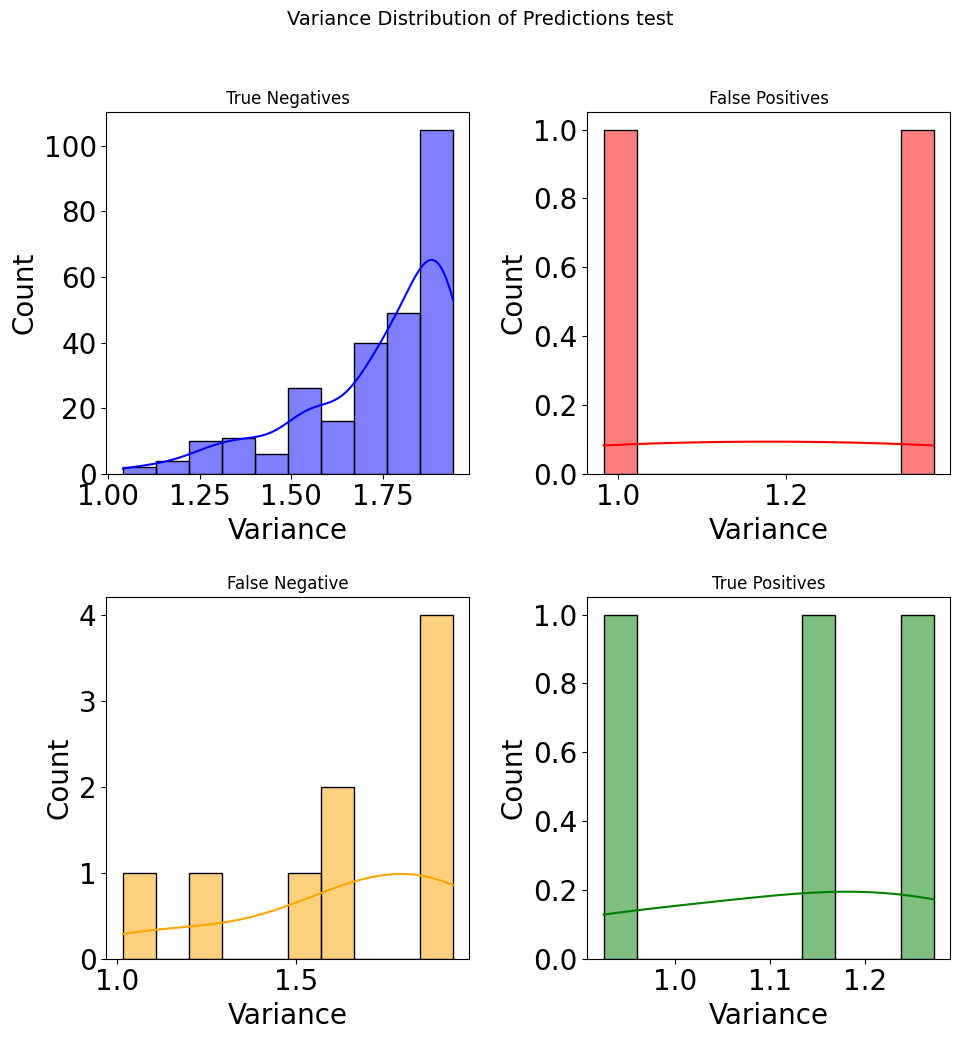

In [200]:
plot_cm_dist_kde(train_observed_pred, train_pred, train_y, 'train')
plot_cm_dist_kde(test_observed_pred, test_pred, test_y, 'test')

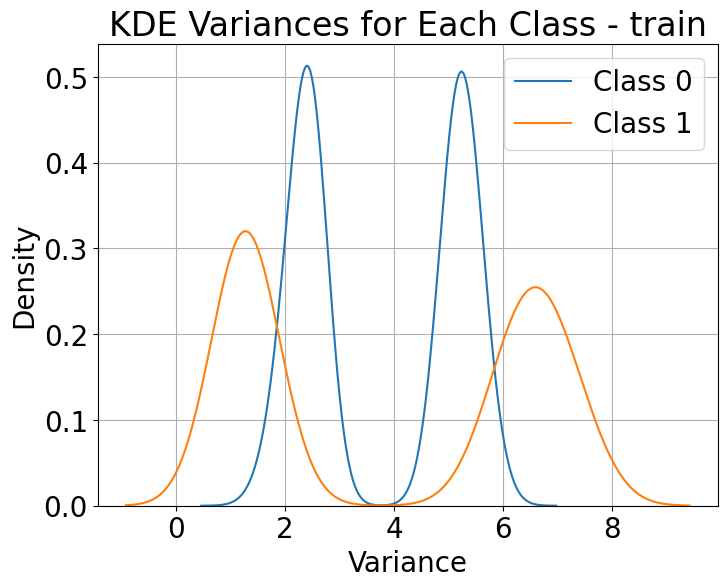

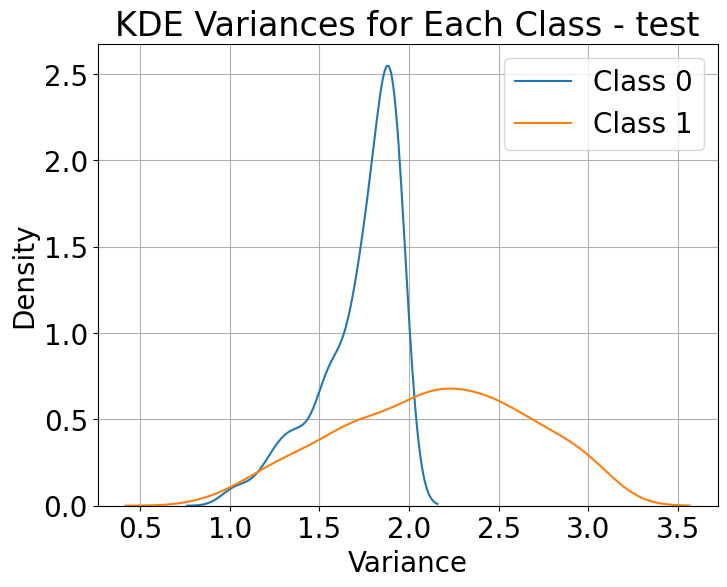

In [109]:
plot_kde(train_observed_pred, 'train')
plot_kde(test_observed_pred, 'test')
# plot_hist(test_observed_prt')

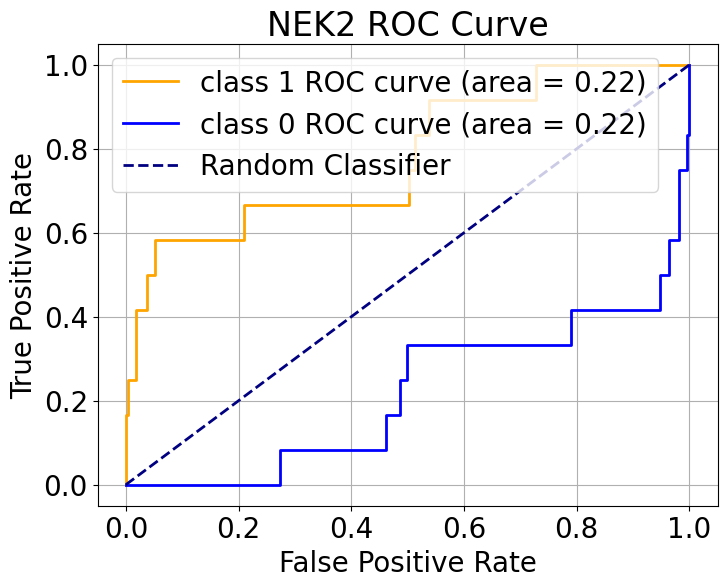

In [106]:
plot_roc(test_y, probabilities)

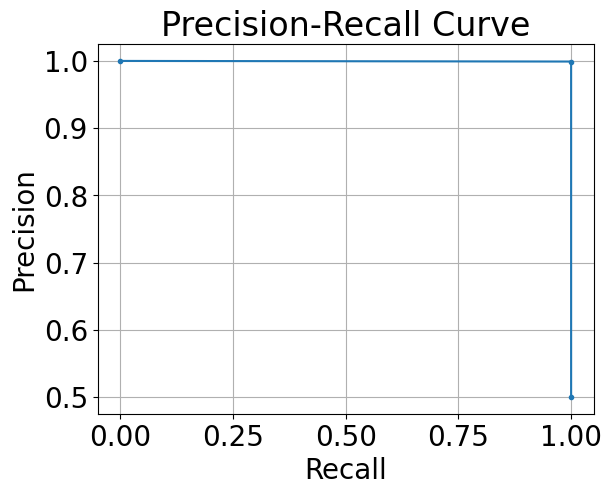

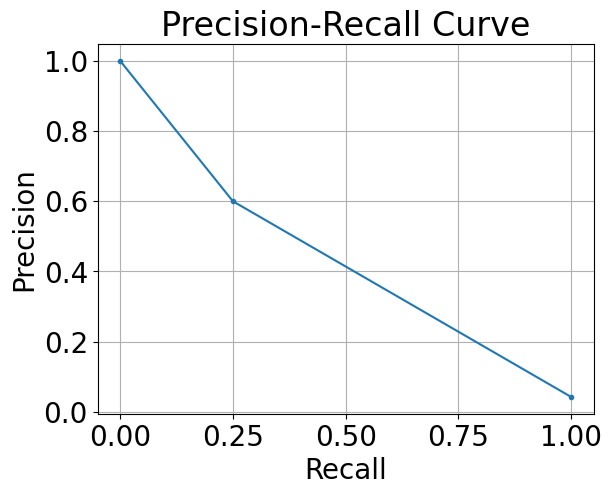

In [148]:
plot_prec_recall(train_y, train_pred, 'train')
plot_prec_recall(test_y, test_pred, 'test')

In [ ]:
plt.rcParams.update({"font.size": 20}) 

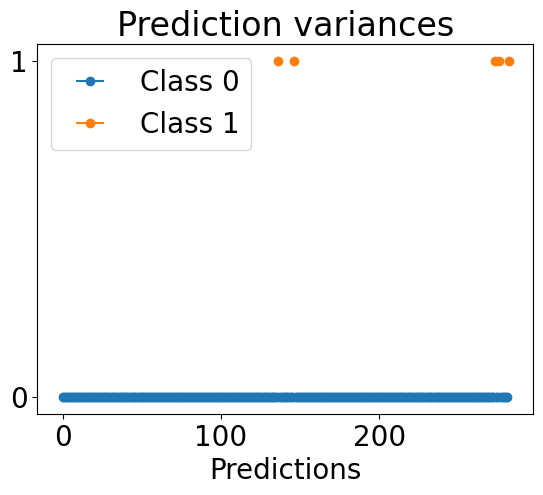

In [141]:
indices0 = np.where(test_pred == 0)[0]
indices1 = np.where(test_pred == 1)[0]

var_class0 = test_observed_pred.variance[0].numpy()
var_class1 = test_observed_pred.variance[1].numpy()
plt.errorbar(indices0, test_pred[indices0], 
             xerr=var_class0[indices0], fmt='o', label='Class 0')

plt.errorbar(indices1, test_pred[indices1], 
             xerr=var_class1[indices1], fmt='o', label='Class 1')


plt.xlabel('Predictions')
plt.yticks([0, 1], ['0', '1'])
plt.title('Prediction variances')
plt.legend()
plt.show()

In [56]:
plot_violin(train_observed_pred, 'train')

ValueError: Per-column arrays must each be 1-dimensional

<Figure size 1000x600 with 0 Axes>

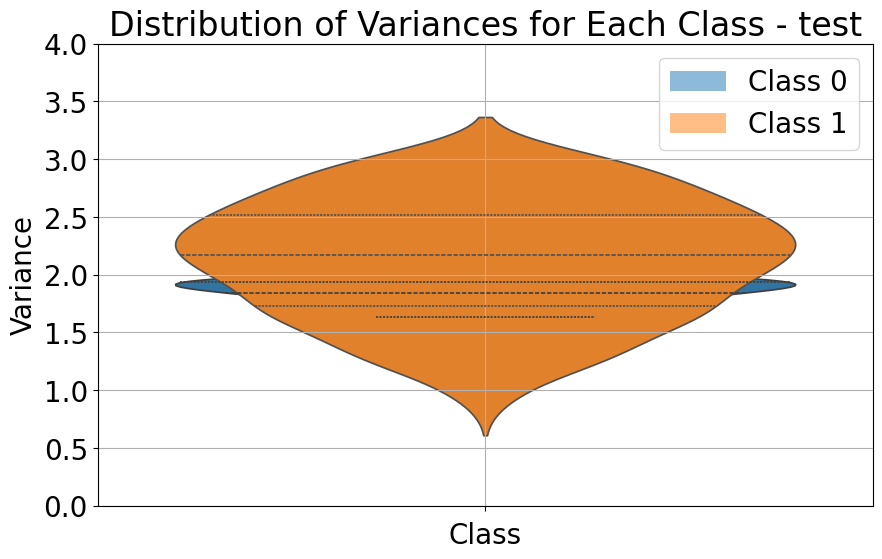

In [36]:
plot_violin(test_observed_pred, 'test', 4)

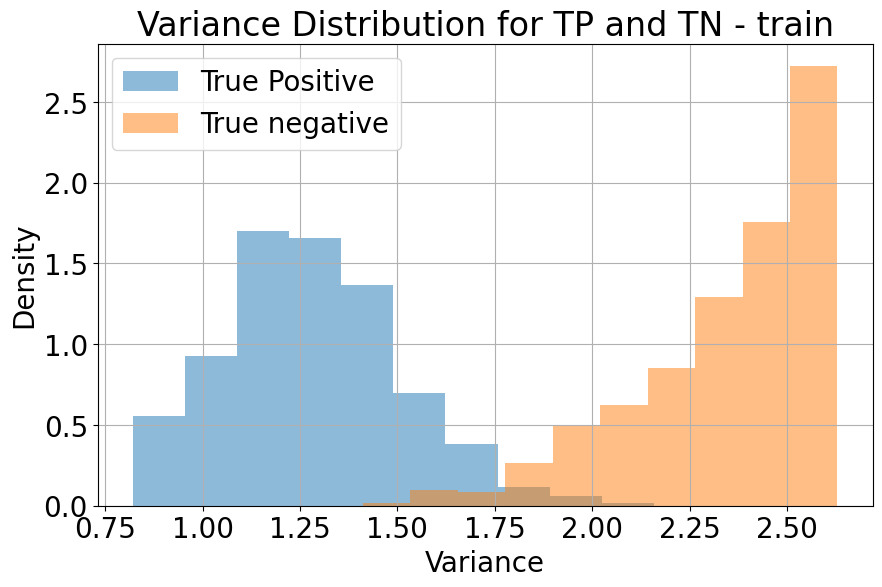

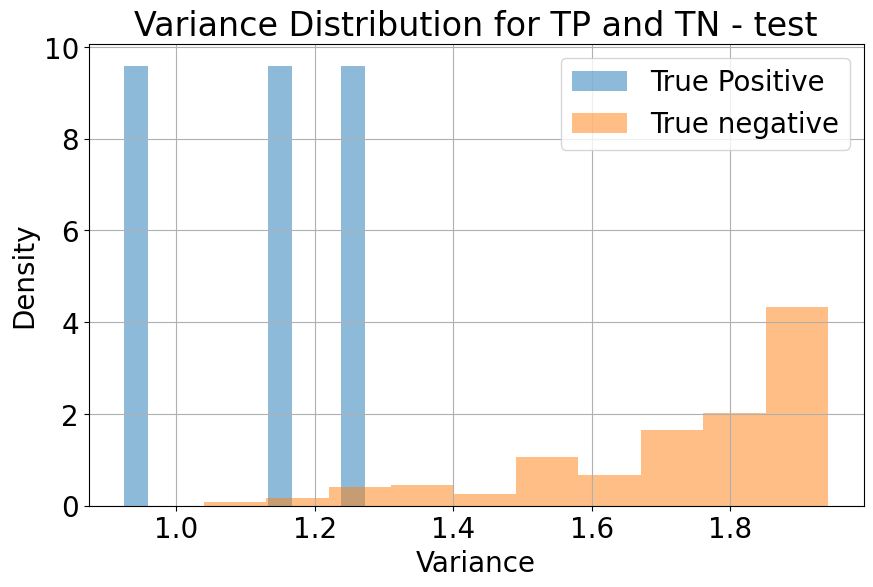

In [78]:
plot_hist_tp_tn(train_observed_pred, train_pred, train_y, 'train')
plot_hist_tp_tn(test_observed_pred, test_pred, test_y, 'test')

In [ ]:
indices = np.where(test_pred == 1)[0]
# indices # array([136, 146, 273, 276, 282]) compared to: 
# tutorial: array([125, 136, 146, 273, 276, 282]) 

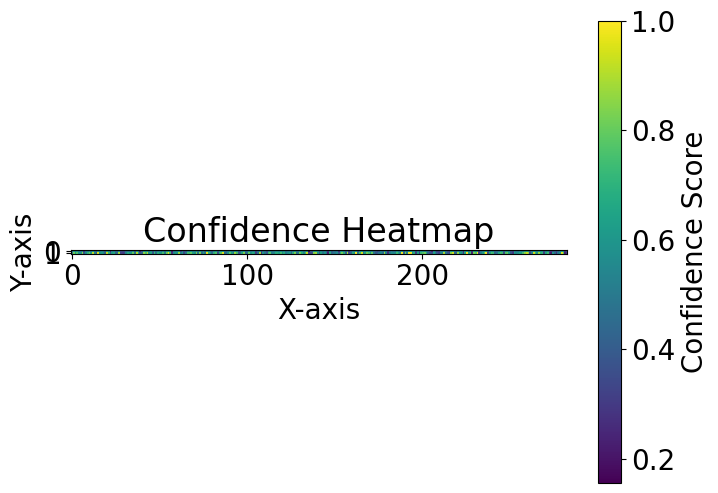

In [80]:
dist = trainer1.model(test_x)
pred_varainces = dist.variance
normalized = pred_varainces/pred_varainces.max() 
normalized.shape
plt.figure(figsize=(8, 6))
plt.imshow(normalized.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Confidence Score')
plt.title('Confidence Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [84]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
# pred_means = dist.loc
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]
# len(test_pred_variance)
# reshaped_pred_var = test_pred_variance2D
# reshaped_pred_var.shape
# test_x.shape, test_y.shape
test_pred_variance

(2, 283)


[1.6291034,
 1.9177444,
 1.8966157,
 1.892793,
 1.7491459,
 1.7799401,
 1.9340205,
 1.3835843,
 1.675812,
 1.9116151,
 1.8931932,
 1.8185174,
 1.9373102,
 1.8282416,
 1.4394991,
 1.940684,
 1.7229818,
 1.7877115,
 1.7060335,
 1.522989,
 1.9352514,
 1.847608,
 1.3803501,
 1.7850816,
 1.8671327,
 1.5124756,
 1.5806372,
 1.92771,
 1.3217995,
 1.2720094,
 1.2966123,
 1.7440996,
 1.8968549,
 1.8813438,
 1.8324778,
 1.8996035,
 1.7432072,
 1.9363666,
 1.8423102,
 1.384456,
 1.538202,
 1.925853,
 1.8825605,
 1.9348595,
 1.8346034,
 1.8085492,
 1.4778013,
 1.8691788,
 1.6796159,
 1.9236803,
 1.7544531,
 1.8324542,
 1.902283,
 1.7199136,
 1.9052429,
 1.9410199,
 1.885851,
 1.0396371,
 1.7559266,
 1.7748036,
 1.7629539,
 1.9365641,
 1.8004761,
 1.7920605,
 1.3606515,
 1.8122158,
 1.929628,
 1.90341,
 1.9079703,
 1.7322148,
 1.7562789,
 1.938327,
 1.6359067,
 1.9213471,
 1.5748135,
 1.7816298,
 1.6884041,
 1.9410741,
 1.8705465,
 1.9143106,
 1.606316,
 1.9152542,
 1.8961964,
 1.3752415,
 1.817310

In [82]:
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
print(var_min, var_max)


0.92472804 3.058735


In [145]:
test_pred_variance2D.mean()

1.9328958

In [209]:
test_observed_pred.variance.numpy()

array([[1.6291034 , 1.9177444 , 1.8966157 , 1.892793  , 1.7491459 ,
        1.7799401 , 1.9340205 , 1.3835843 , 1.675812  , 1.9116151 ,
        1.8931932 , 1.8185174 , 1.9373102 , 1.8282416 , 1.4394991 ,
        1.940684  , 1.7229818 , 1.7877115 , 1.7060335 , 1.522989  ,
        1.9352514 , 1.847608  , 1.3803501 , 1.7850816 , 1.8671327 ,
        1.5124756 , 1.5806372 , 1.92771   , 1.3217995 , 1.2720094 ,
        1.2966123 , 1.7440996 , 1.8968549 , 1.8813438 , 1.8324778 ,
        1.8996035 , 1.7432072 , 1.9363666 , 1.8423102 , 1.384456  ,
        1.538202  , 1.925853  , 1.8825605 , 1.9348595 , 1.8346034 ,
        1.8085492 , 1.4778013 , 1.8691788 , 1.6796159 , 1.9236803 ,
        1.7544531 , 1.8324542 , 1.902283  , 1.7199136 , 1.9052429 ,
        1.9410199 , 1.885851  , 1.0396371 , 1.7559266 , 1.7748036 ,
        1.7629539 , 1.9365641 , 1.8004761 , 1.7920605 , 1.3606515 ,
        1.8122158 , 1.929628  , 1.90341   , 1.9079703 , 1.7322148 ,
        1.7562789 , 1.938327  , 1.6359067 , 1.92

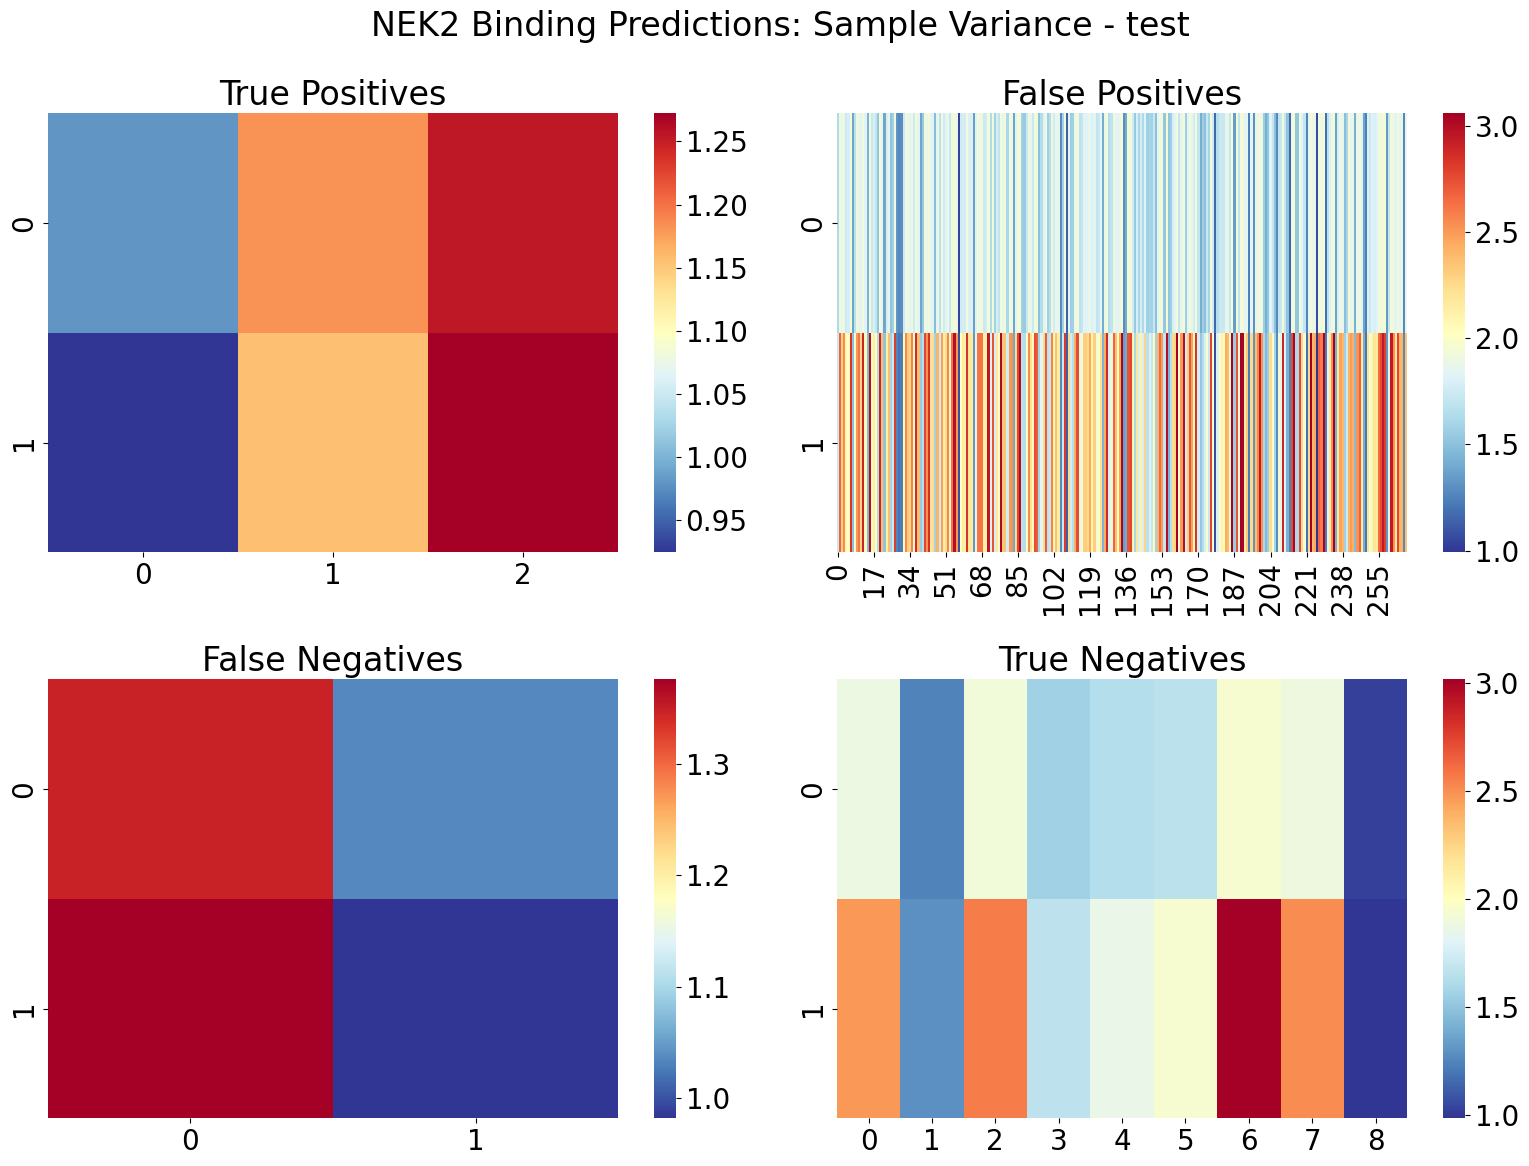

In [216]:
plot_variance_cm(test_observed_pred, test_y.numpy(), test_pred, 'test')

In [158]:
# # TEST
# test_var = test_observed_pred.variance.numpy().tolist()
# plt.figure(figsize=(10, 6))
# for class_idx in range(2):
#     class_variances = test_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')

# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Distribution of Variances for Each Class - TEST')
# plt.legend()
# plt.grid(True)
# plt.show();


# plt.figure(figsize=(10, 6))
# for class_idx in range(2): 
#     class_variances = test_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')
#     sns.violinplot(data=test_observed_pred.variance[class_idx].numpy().tolist(), inner="quartile")
# plt.xlabel('Class')

# plt.ylabel('Variance')
# plt.ylim(0,4)
# plt.legend()
# plt.title('Distribution of Variances for Each Class - TEST')
# plt.grid(True)
# plt.show();

# plt.figure(figsize=(10, 6))
# for i in range(len(test_var)):
#     sns.kdeplot(test_var[i], label=f'Class {i}')
# plt.xlabel('Variance')
# plt.ylabel('Density')
# plt.title('KDE Variances for Each Class - TEST')
# plt.legend()
# plt.grid(True)
# plt.show();

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/2465208877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


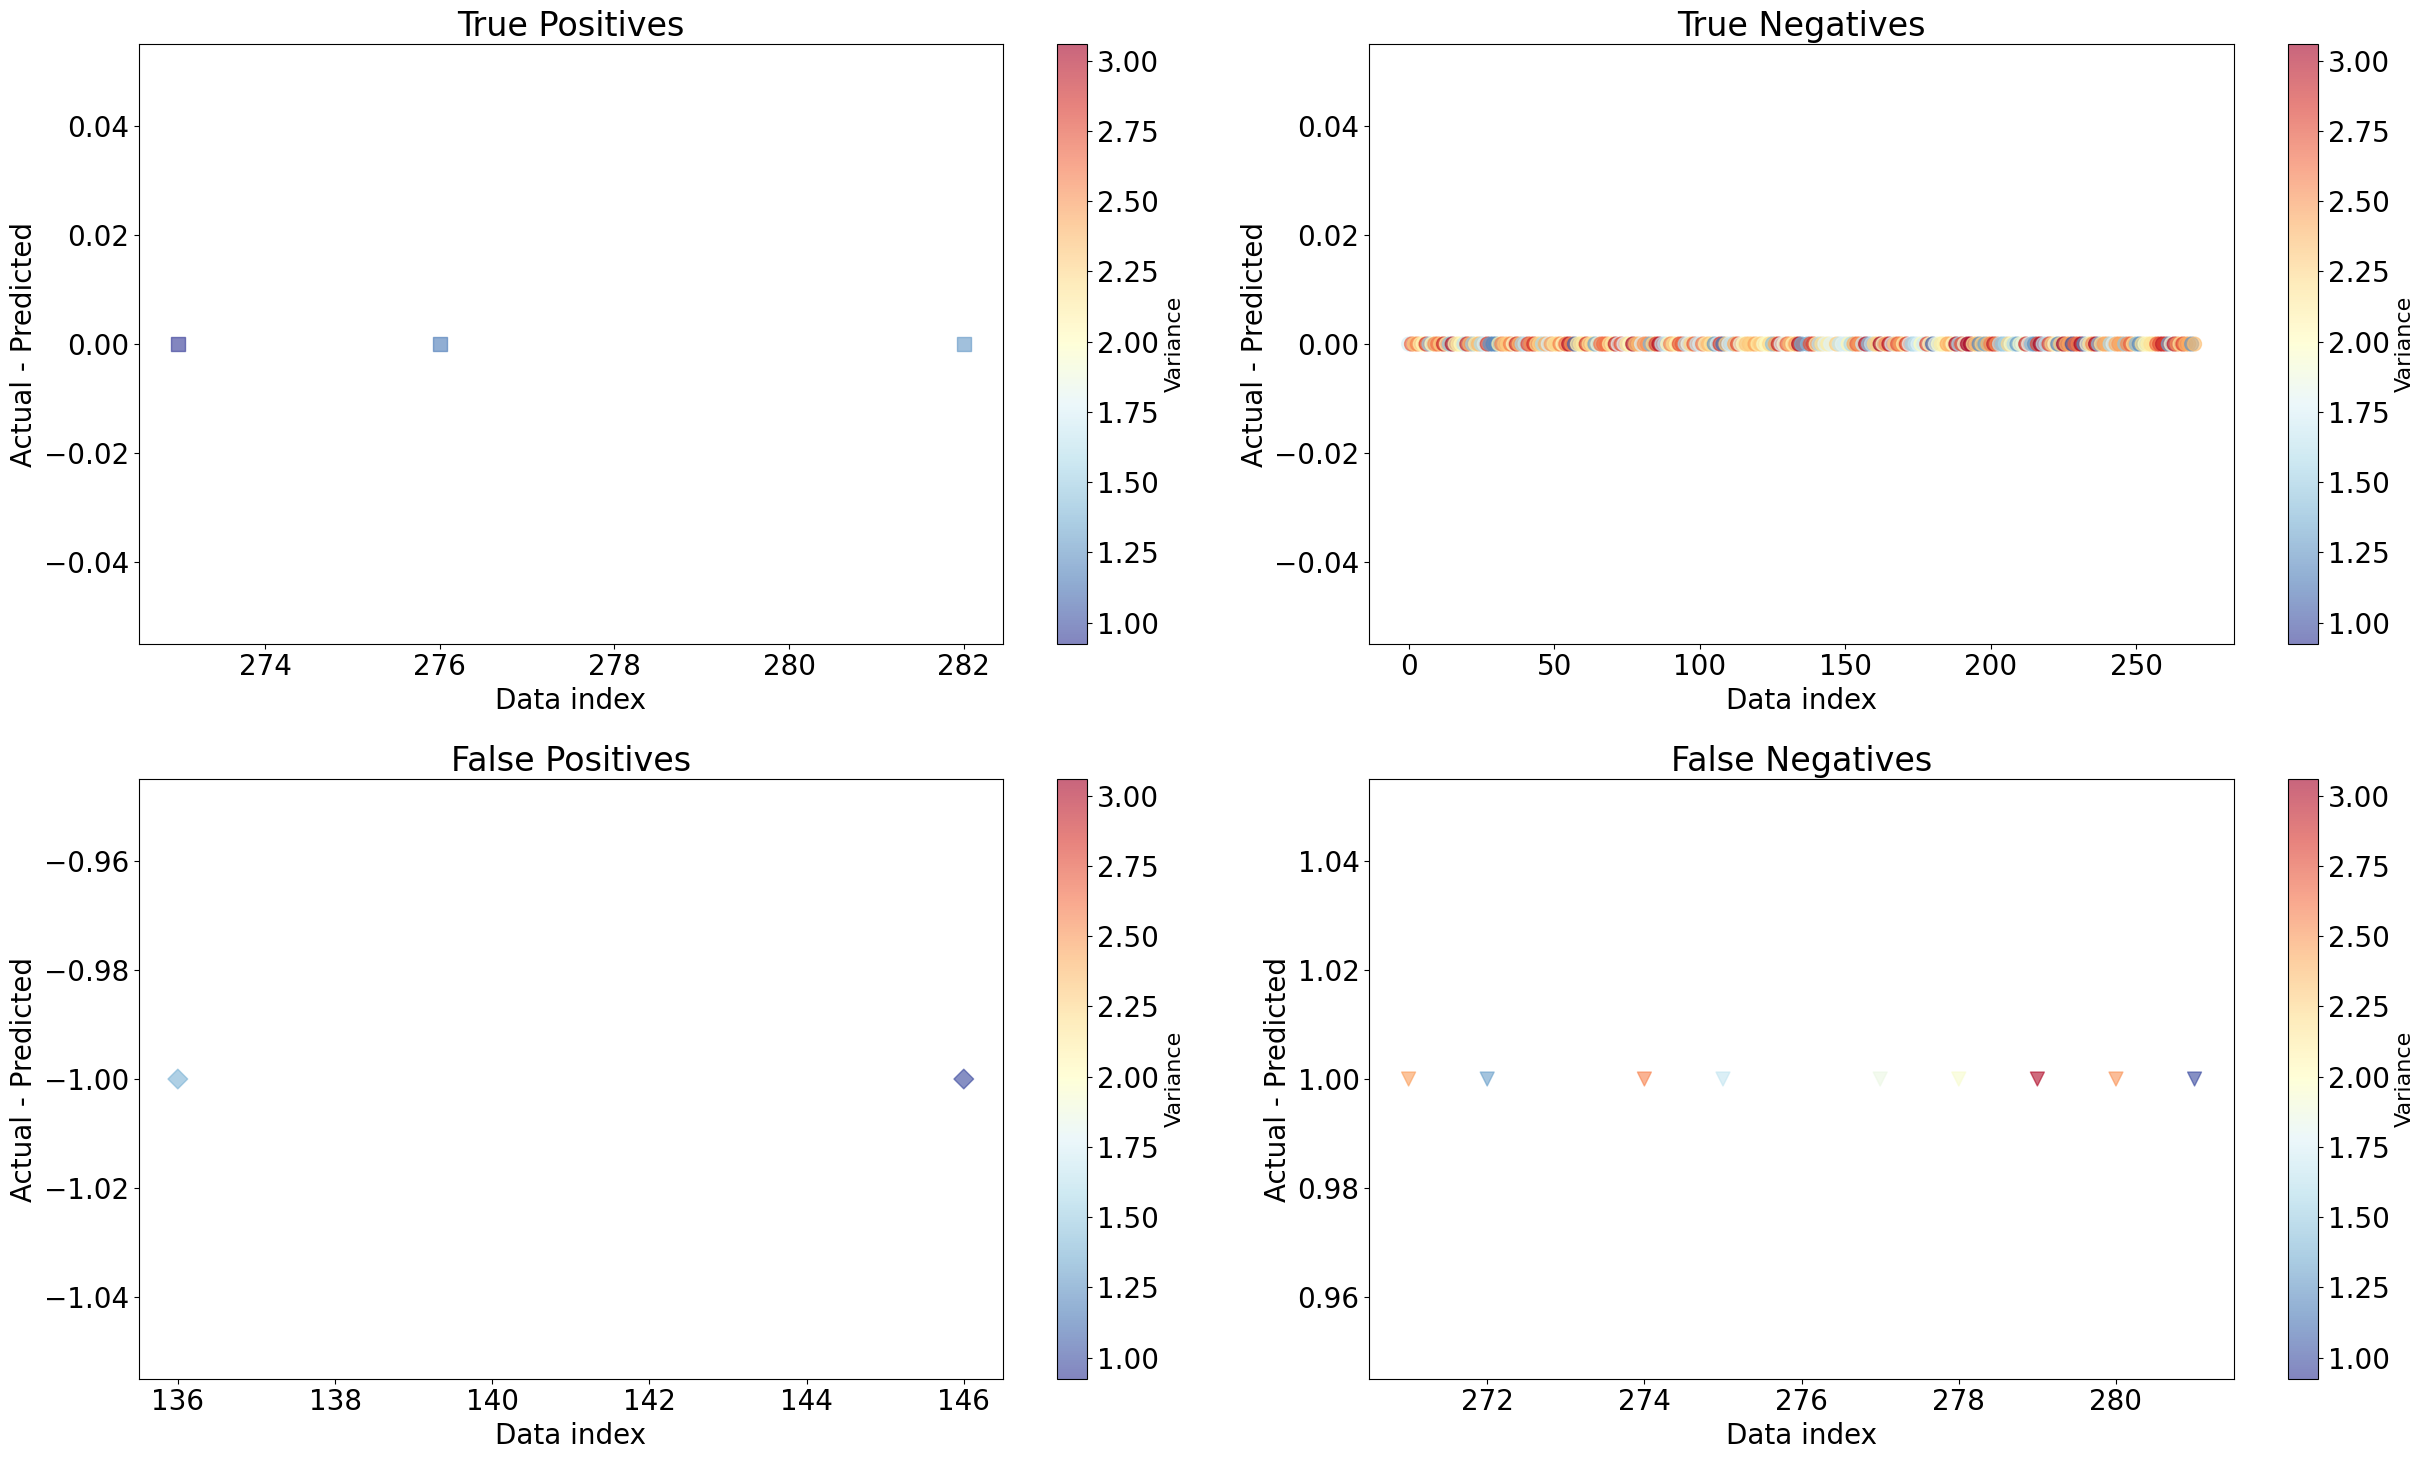

<Figure size 640x480 with 0 Axes>

In [184]:
marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig, ax = plt.subplots(2, 2, figsize=(25, 15))
true_labels = test_y.numpy()


true_pos = np.where((test_pred == 1) & (true_labels == 1))[0] 
true_neg = np.where((test_pred == 0) & (true_labels == 0))[0]
false_pos = np.where((test_pred == 1) & (true_labels == 0))[0] 
false_neg = np.where((test_pred == 0) & (true_labels == 1))[0] 

var_tp = test_observed_pred.variance[1, true_pos].numpy()
var_tn = test_observed_pred.variance[0, true_neg].numpy()
var_fp = test_observed_pred.variance[1, false_pos].numpy()
var_fn = test_observed_pred.variance[0, false_neg].numpy()

sc_tp = ax[0, 0].scatter(true_pos, (test_y[true_pos] - test_pred[true_pos]), c=test_pred_variance2D[1, true_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[0])
ax[0, 0].set_title('True Positives')
ax[0, 0].set_xlabel('Data index')
ax[0, 0].set_ylabel('Actual - Predicted')


sc_tn = ax[0, 1].scatter(true_neg, (test_y[true_neg] - test_pred[true_neg]), c=test_pred_variance2D[1, true_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[1])
ax[0, 1].set_title('True Negatives')
ax[0, 1].set_xlabel('Data index')
ax[0, 1].set_ylabel('Actual - Predicted')


sc_fp = ax[1, 0].scatter(false_pos, (test_y[false_pos] - test_pred[false_pos]), c=test_pred_variance2D[1, false_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[2])
ax[1, 0].set_title('False Positives')
ax[1, 0].set_xlabel('Data index')
ax[1, 0].set_ylabel('Actual - Predicted')


sc_fn = ax[1, 1].scatter(false_neg, (test_y[false_neg] - test_pred[false_neg]), c=test_pred_variance2D[1, false_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[3])
ax[1, 1].set_title('False Negatives')
ax[1, 1].set_xlabel('Data index')
ax[1, 1].set_ylabel('Actual - Predicted')

cbar_tp = fig.colorbar(sc_tp, ax=ax[0, 0], location='right')
cbar_tp.set_label('Variance', fontsize=16)

cbar_tn = fig.colorbar(sc_tn, ax=ax[0, 1], location='right')
cbar_tn.set_label('Variance', fontsize=16)

cbar_fp = fig.colorbar(sc_fp, ax=ax[1, 0], location='right')
cbar_fp.set_label('Variance', fontsize=16)

cbar_fn = fig.colorbar(sc_fn, ax=ax[1, 1], location='right')
cbar_fn.set_label('Variance', fontsize=16)

plt.tight_layout()
plt.show()
# cbar.set_label('Variance', fontsize=16)

plt.tight_layout()
plt.savefig(f'nek2_binding_scatter_dist_test.png')
plt.show()

In [ ]:
# calibratio
from sklearn.calibration import calibration_curve
# n_bins = 10
# prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

# plt.figure(figsize=(8, 6))
# plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Plot')
# plt.grid(True)
# plt.show(); 


In [153]:
with torch.no_grad(): 
    test_dist = model1(test_x)
    pred_means = test_dist.mean 
    pred_var = test_dist.variance
print(pred_var.shape)
# pred_var_reshaped = pred_var.reshape(2, -1)
# pred_var_reshaped.shape
pred_var[1]

torch.Size([2, 283])


tensor([1.4932, 2.4906, 1.9573, 2.3587, 1.7798, 1.7824, 2.5823, 1.2007, 1.7613,
        2.1930, 2.4234, 1.8794, 2.7977, 1.6909, 1.2127, 2.9280, 1.8291, 1.8957,
        1.7169, 1.3127, 2.8227, 2.1490, 1.1636, 1.9140, 2.0618, 1.3256, 1.4134,
        2.6966, 0.9872, 0.9351, 1.0037, 1.6997, 2.0664, 1.9036, 1.8394, 2.4204,
        1.5225, 2.7888, 1.9902, 1.1613, 1.3008, 2.6176, 2.3334, 2.7595, 1.8051,
        2.0246, 1.2603, 2.2432, 1.4905, 2.1133, 1.9017, 1.8264, 2.2909, 1.6248,
        2.4545, 2.9557, 2.2950, 0.8468, 1.7529, 1.9189, 1.8347, 2.6564, 1.6103,
        1.8934, 1.0816, 1.5517, 2.2943, 2.2612, 2.4078, 1.9959, 1.8146, 2.5461,
        1.5099, 2.5420, 1.4158, 1.9769, 1.5253, 2.9828, 2.1296, 1.8838, 1.3814,
        2.1705, 2.3573, 1.1152, 2.0384, 2.3980, 2.9404, 1.4074, 1.3728, 1.8158,
        2.3918, 1.9496, 1.6293, 2.6558, 2.3030, 1.2352, 1.4562, 2.0497, 2.5537,
        1.3956, 1.5086, 2.4106, 1.8104, 2.0928, 1.8792, 0.9585, 1.4394, 2.7115,
        0.8365, 1.8695, 1.5118, 1.2348, 

torch.Size([283, 283])
tensor([[1.4309, 1.4309, 1.4309,  ..., 1.4309, 1.4309, 1.4309],
        [1.8521, 1.8521, 1.8521,  ..., 1.8521, 1.8521, 1.8521],
        [1.5809, 1.5809, 1.5809,  ..., 1.5809, 1.5809, 1.5809],
        ...,
        [1.8150, 1.8150, 1.8150,  ..., 1.8150, 1.8150, 1.8150],
        [0.8326, 0.8326, 0.8326,  ..., 0.8326, 0.8326, 0.8326],
        [1.1326, 1.1326, 1.1326,  ..., 1.1326, 1.1326, 1.1326]])
torch.Size([283, 283])
tensor([[1.4932, 1.4932, 1.4932,  ..., 1.4932, 1.4932, 1.4932],
        [2.4906, 2.4906, 2.4906,  ..., 2.4906, 2.4906, 2.4906],
        [1.9573, 1.9573, 1.9573,  ..., 1.9573, 1.9573, 1.9573],
        ...,
        [2.3162, 2.3162, 2.3162,  ..., 2.3162, 2.3162, 2.3162],
        [0.6777, 0.6777, 0.6777,  ..., 0.6777, 0.6777, 0.6777],
        [0.9741, 0.9741, 0.9741,  ..., 0.9741, 0.9741, 0.9741]])


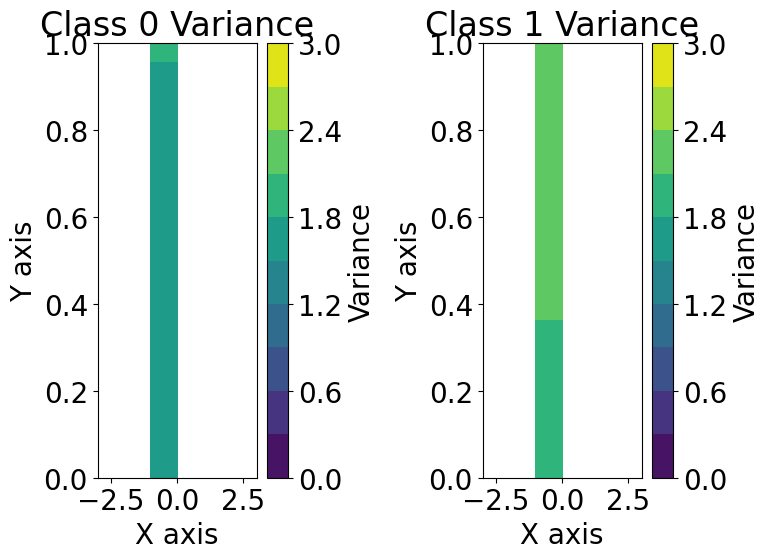

In [154]:
levels = np.linspace(0, 3, 11)
plt.figure(figsize=(8, 6))

x_values = test_x[:, 0].numpy()
y_values = test_y.numpy()
# y = np.linspace(test_y.min(), test_y.max(), 283)
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

for class_idx in range(2):
    plt.subplot(1, 2, class_idx + 1)
    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # print(pred_var_copy)
    # pred_var_reshaped = pred_var_copy.reshape((2, 283, 283))
    # plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
    # pred_var_copy = np.repeat(pred_var_copy[:, :, np.newaxis], x_mesh.shape[1], axis=2)
    print(pred_var_copy.shape)
    print(pred_var_copy)
    plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

    plt.colorbar(label='Variance')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f'Class {class_idx} Variance')


plt.tight_layout()
plt.show();


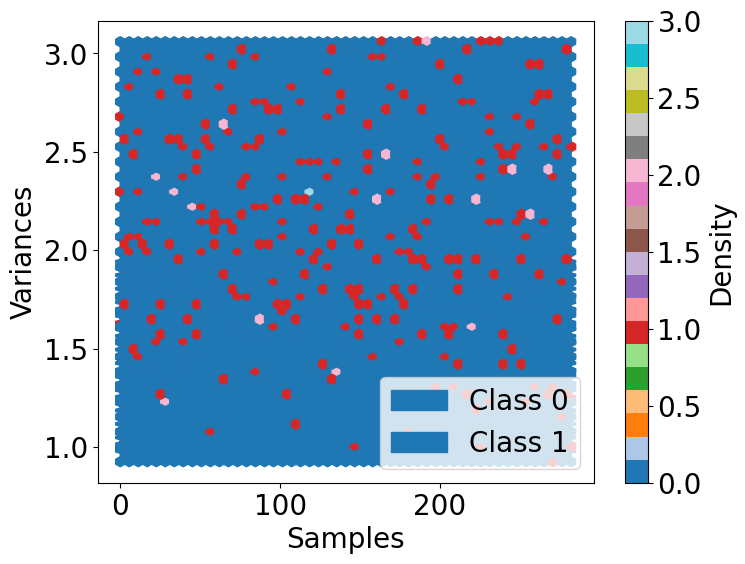

In [151]:
samples = np.arange(len(test_x))
vars_class0 = test_pred_variance2D[0]
vars_class1 = test_pred_variance2D[1]

plt.figure(figsize=(8, 6))
plt.hexbin(samples, vars_class0, gridsize=50, cmap='tab20', label='Class 0')
plt.hexbin(samples, vars_class1, gridsize=50, cmap='tab20', label='Class 1')
plt.colorbar(label='Density')
plt.xlabel('Samples')
plt.ylabel('Variances')
plt.legend()
plt.show()


In [ ]:
pred_var[1].shape

In [ ]:
class_0_variances = pred_var[0]
class_1_variances = pred_var[1]

x_min, x_max = test_x[:, 0].min() - 1, test_x[:, 0].max() + 1
y_min, y_max = test_x[:, 1].min() - 1, test_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

print(xx.shape, yy.shape)
plt.figure()
plt.contourf(xx, yy, np.sqrt(pred_var[0].reshape(xx.shape)), alpha=0.8)
plt.contourf(xx, yy, np.sqrt(pred_var[1].reshape(xx.shape)), alpha=0.8)
plt.scatter(x_values[:, 0], x_values[:, 1], c=y_values, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Contour Plot with Variances')
plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/342155008.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(np.arange(len(test_y)), test_pred, test_pred_variance, cmap='viridis')


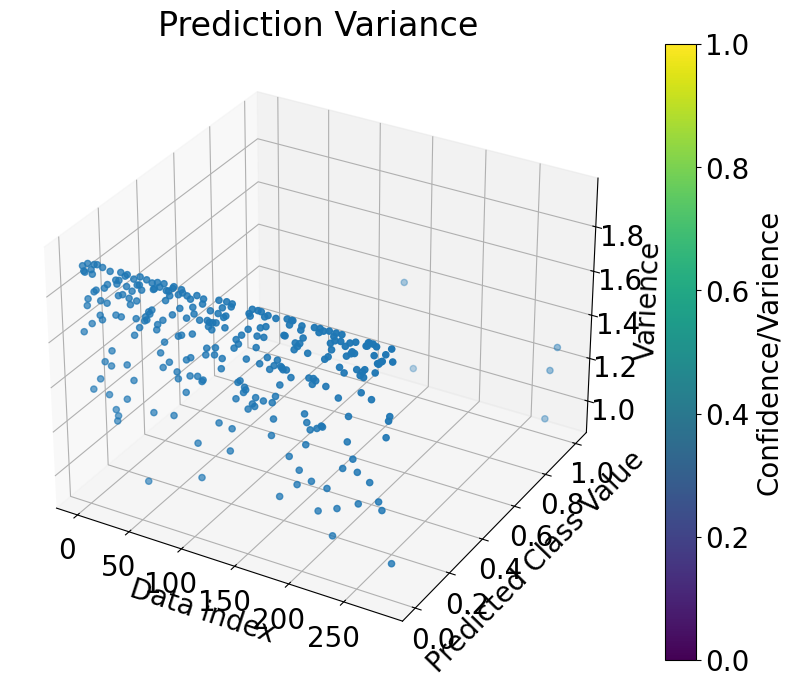

In [149]:
# scatter 3d? 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(np.arange(len(test_y)), test_pred, test_pred_variance, cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Varience')

ax.set_xlabel('Data index')
ax.set_ylabel('Predicted Class Value')
ax.set_zlabel('Varience')
ax.set_title('Prediction Variance')
plt.show();


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/1138995925.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


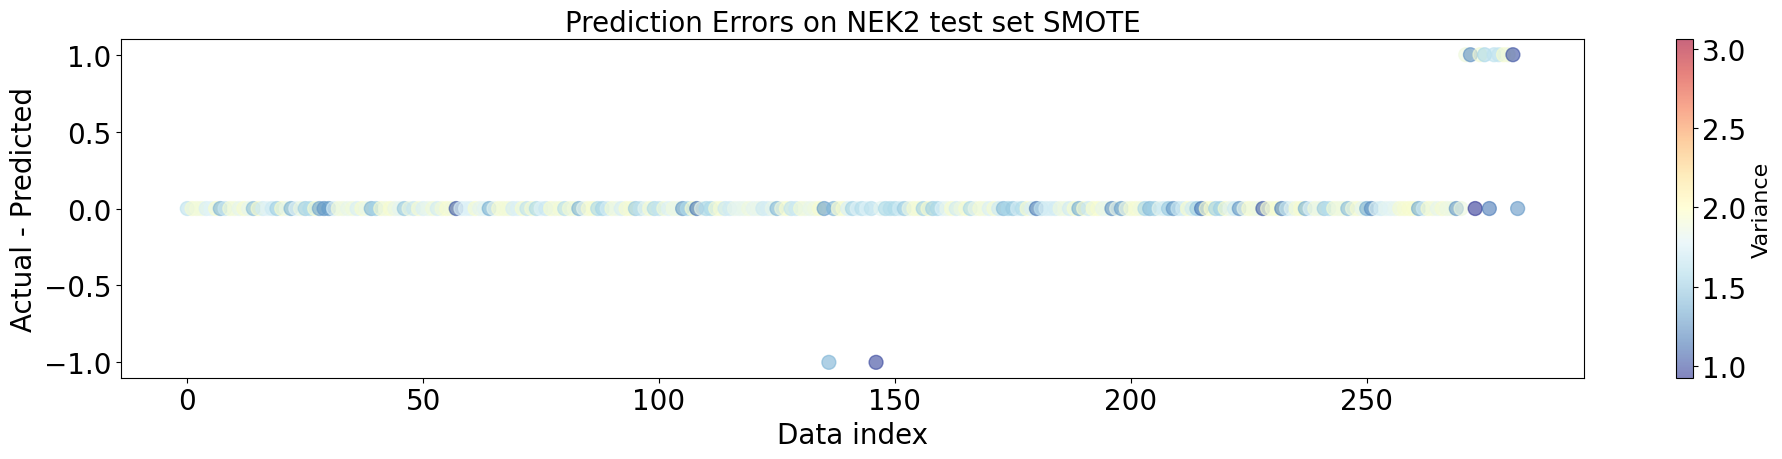

In [87]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/3513342963.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


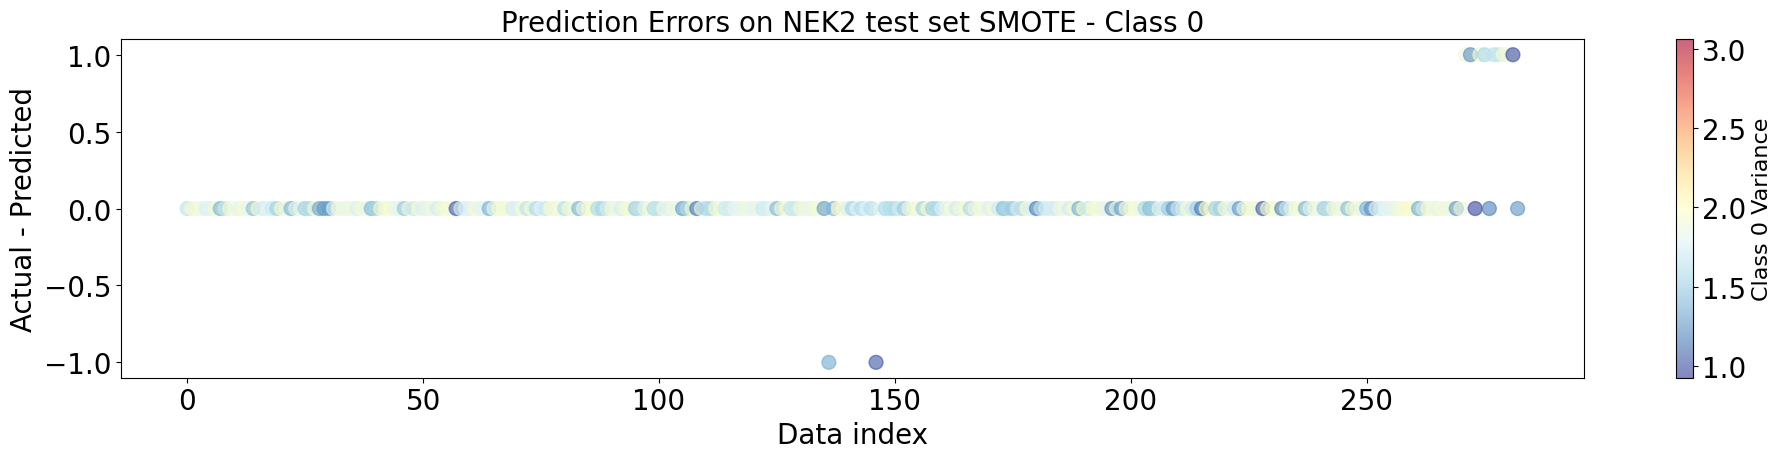

In [86]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 0",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_40829/3654803106.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu').reversed()


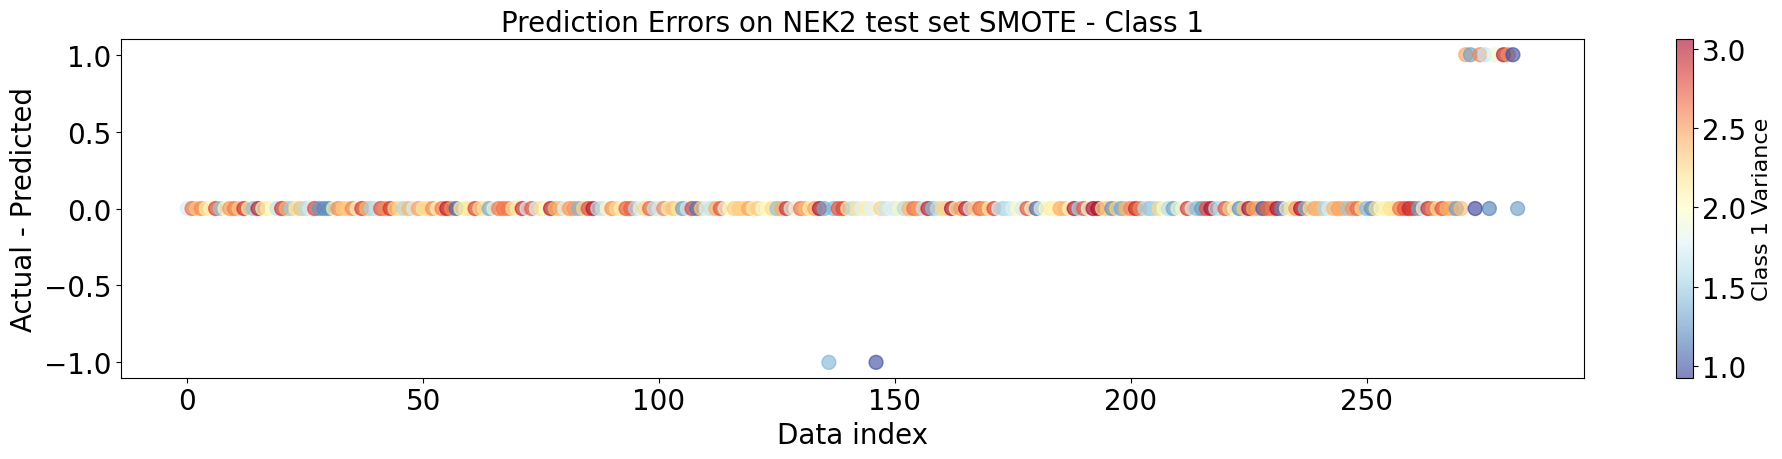

In [85]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 1",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

In [ ]:
test_pred_variance2D[1][0:2]

In [ ]:
test_pred_variance2D[0][0:2]

In [ ]:
# train_var = train_observed_pred.variance.numpy().tolist()
# plt.figure(figsize=(10, 6))
# for class_idx in range(2):
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')

# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.savefig('nek2train_hist.png')
# plt.show();


# plt.figure(figsize=(10, 6))
# for class_idx in range(2): 
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')
#     sns.violinplot(data=train_observed_pred.variance[class_idx].numpy().tolist(), inner="quartile")
# plt.xlabel('Class')

# plt.ylabel('Variance')
# plt.ylim(0,10)
# plt.legend()
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.grid(True)
# plt.show();

# plt.figure(figsize=(10, 6))
# for i in range(len(train_var)):
#     sns.kdeplot(train_var[i], label=f'Class {i}')
# plt.xlabel('Variance')
# plt.ylabel('Density')
# plt.title('KDE Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.show();

In [ ]:
# folds = [1] 
# for fold in folds: 
#     fold = str(fold)
#     trainx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainX.csv')
#     trainy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainY.csv')
#     testx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testX.csv')
#     testy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testY.csv')
#     # print(f'trainx :{trainx.shape}, trainy shape: {trainy.shape} \t testx: {testx.shape}, testy: {testy.shape}')
    
#     oversample_trial = SMOTE()
#     trial_train_x, trial_train_y_df = oversample_trial.fit_resample(trainx, trainy)
#     print(f'new trainx :{new_train_x_df.shape}, new trainy shape: {new_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'new trial trainx :{trial_train_x.shape}, new trial trainy shape: {trial_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'trial train same: {new_train_x_df.equals(trial_train_x)}')
#     print(f'test train same: {new_train_y_df.equals(trial_train_y_df)}')
#     print(f'trial test same: {test_x_df.equals(testx)}')
#     print(f'test test same: {test_y_df.equals(testy)}')
#     # print(list(new_train_x_df.values.flatten().tolist()))
#     # print(list(trial_train_x.values.flatten().tolist()))
#     diff_trainx = new_train_x_df.values != trial_train_x.values
#     which_diff_trainx = np.where(diff_trainx)
#     print(f"indices with differences in train x:", which_diff_trainx)
#     for i, val in enumerate(list(new_train_x_df.values.flatten().tolist())): 
#         other_val = list(trial_train_x.values.flatten().tolist())[i]
#         if (val != other_val): 
#             print(f'difference at index: {i}, new train y df: {val}, trial: {other_val}')
      
            